We will expect the following folder structure for the data:
```bash
Data 
├─ Folder1 
│  ├─ image1 
│  ├─ image2 
│  └─ etc 
├─ Folder2 
│  ├─ image1 
│  ├─ image2 
│  └─ etc 
├─ metadata1.csv 
└─ metadata2.csv
```



In [2]:
data_root       = 'Data' # Folder where all data sources are stored
data_folders    = 'ImageData' # List of folders containing images in .jpg format
data_meta       = ['emotic-relabelled.csv',
                'hgel-relabelled.csv'] # List of metadata corresponding to previous list of folders in .csv format. In our case we relabelled some of the data, so this is different from original metadata.
meta_root       = 'Metadata'

In [12]:
import pandas as pd
import ast
import os
from sklearn.model_selection import train_test_split


meta_list = []

for meta_file in data_meta:
    df = pd.read_csv(os.path.join(data_root,meta_file))
    df['objects']           = df['objects_final'].apply(ast.literal_eval)
    df['o_old']             = df['objects_old'].apply(ast.literal_eval)
    df['original_width']    = df['o_old'].apply(lambda x: x['original_width'])
    df['original_height']    = df['o_old'].apply(lambda x: x['original_height'])
    df.drop(columns=['objects_old','objects_new','objects_final','n_old','n_final','o_old'], inplace = True)
    meta_list.append(df)

colset = set(meta_list[0].columns)
if all(set(df.columns) for df in meta_list): 
    meta = pd.concat(meta_list, ignore_index = True)
else:
    print('Mismatched columns in metadata.')

In [7]:
meta.head(5)

,file_name,objects,original_width,original_height
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300


If `interative_stratification` isn't installed:

In [ ]:
#!pip install iterative-stratification

To handle the multiple labels associated to every picture we use a multilabel stratifier.

In [9]:

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

meta['emotions'] = meta['objects'].apply(lambda x: x['categories'])

mlb = MultiLabelBinarizer()

X = meta[['file_name']]
y = mlb.fit_transform(meta['emotions'])

mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx = np.arange(len(meta))

(train_idx, test_idx), = mss.split(idx, y)

train_df = meta.iloc[train_idx].reset_index(drop=True)
test_df  = meta.iloc[test_idx].reset_index(drop=True)

train_df.to_csv(os.path.join(meta_root,'train_meta.csv'),index=False)
test_df.to_csv(os.path.join(meta_root,'test_meta.csv'),index=False)

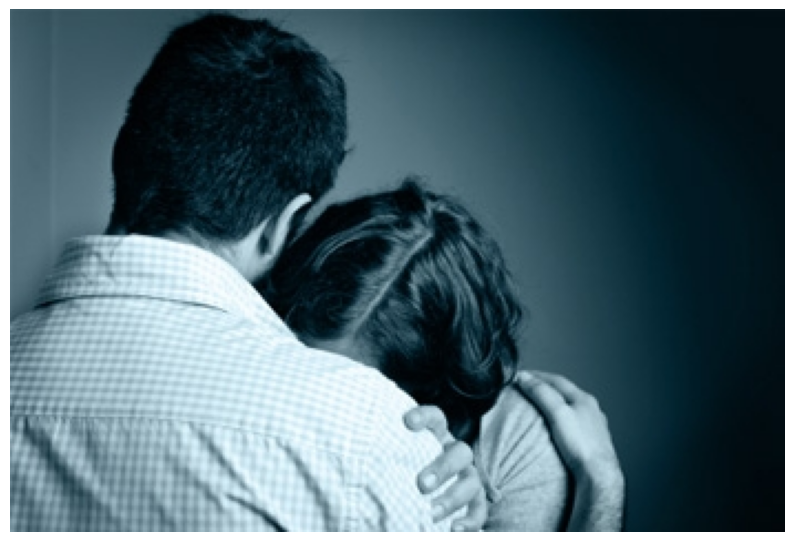

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

def display_image(row, data_root='Data'):
    """
    Display an image from the dataset
    Args:
        row: pandas Series containing 'source_folder' and 'file_name'
        data_root: root directory containing image folders
    """
    img_path = os.path.join(data_root, data_folders, row['file_name'])
    try:
        img = Image.open(img_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error loading image: {img_path}")
        print(f"Error message: {str(e)}")

# Test with first image from training set
display_image(test_df.iloc[0])